# Introduction

In this workshop, we will estimate the protective efficacy of a new vector control tool, 'ceiling nets,' using data from a hypothetical cluster-randomized controlled trial generated through computer simulation.

About ceiling nets: https://bmjopen.bmj.com/content/15/1/e087832.info

### Importing libraries

In [11]:
# It might take some time, better to run the code in advance of the course.

install.packages("lme4")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Rdpack’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’




In [12]:
library(tidyverse)
library(MASS)
library(lme4)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [13]:
# To make plots
theme <- theme(
            plot.title = element_text(size=20,face="bold"),
            legend.position = "top",
            legend.title = element_blank(),
            axis.text = element_text(size=15),
            axis.title = element_text(size=18,face="bold"),
            axis.line = element_line(colour = "black"),
            plot.margin = unit(c(1, 2, 1, 1), "lines"),
            panel.background = element_blank())

# Participant list


First, you got a cohort participant list from local staff.


*   Cohort children are supposed to be aged 6 month to 14 years old.

*   Variables are the following:

    1.   **cluster_id**: ID for each cluster
    2.   **cohort_id**: Unique identifier for each participant
    3. **name_f**: First name of the participant
    4. **name_l**: Last name of the participant
    5. **birth**: Birthday of the participant
    6. **name_labtec**: Name of lab tech respondible for the cluster



In [14]:
df_cohort <- read.csv("./list_cohort.csv")

In [15]:
head(df_cohort,10)

,cluster_id,cohort_id,name_f,name_l,birth,name_labtec
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cl01,cl01_01,Sakeena,al-Hoque,2012-03-26,Nicole
2,cl01,cl01_02,Mitchell,Gonzales,2017-01-02,Nicole
3,cl01,cl01_03,Anthony,Simmons,2024-08-15,Nicole
4,cl01,cl01_04,Alyssa,Rivera,2016-10-03,Nicole
5,cl01,cl01_05,Timothy,Vlajic,2015-09-10,Nicole
6,cl01,cl01_06,Mana,White,2018-08-09,Nicole
7,cl01,cl01_07,Chykeiljah,Rea,2022-05-22,Nicole
8,cl01,cl01_08,Laneesha,Rusk,2011-07-23,Nicole
9,cl01,cl01_09,Mujaahida,el-Malak,2021-01-02,Nicole


In [16]:
# How many cluster IDs?
unique(df_cohort$cluster_id)

[1] "cl01" "cl02" "cl03" "cl04" "cl05" "cl06" "cl07" "cl08" "cl09" "cl10"
[11] "cl11" "cl12" "cl13" "cl14" "cl15" "cl16" "cl17" "cl18" "cl19" "cl20"

In [17]:
# Number of participants per cluster
df_cohort %>% count(cluster_id)

cluster_id,n
<chr>,<int>
cl01,38
cl02,38
cl03,38
cl04,38
cl05,38
cl06,38
cl07,38
cl08,38
cl09,38


In [18]:
# Lab tech name?
print(unique(df_cohort$name_labtec))

 [1] " Nicole"     " Luis"       " Rustin"     " Phuc Danny" " Kimberly"  
 [6] " Ghaaziya"   " Clifford"   " Antonia"    " Felonice"   " Jordan"    
[11] " Hysoonie"   " Saleet"     " Michael"    " Patrick"    " Darian"    
[16] " Sean"       " Megan"      " Sharaf"     " Rashiah"    " Aaron"     


In [19]:
# Age of participants?
date_survey <- as.Date("2025/04/01")
df_cohort$age <- floor(interval(df_cohort$birth, date_survey) / years(1))

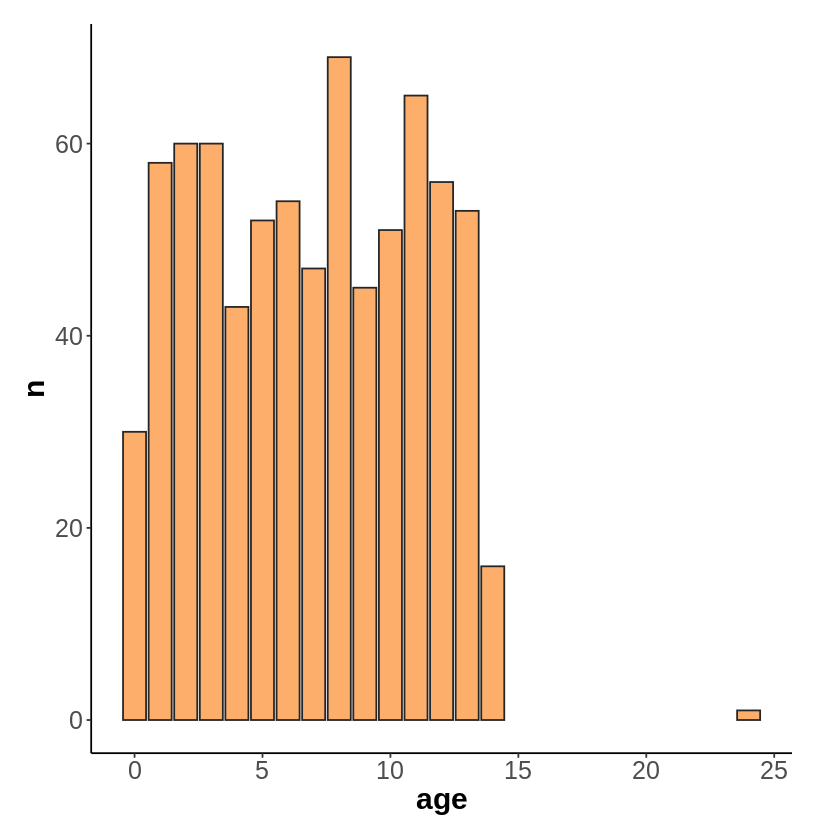

In [20]:
df_cohort_age <- df_cohort %>% count(age)

ggplot(data = df_cohort_age, aes(x = age, y = n))+
  geom_bar(stat = "identity", fill = "#fdae6b", color = "#252525")+
  theme

In [21]:
df_cohort %>% filter(age > 14)

cluster_id,cohort_id,name_f,name_l,birth,name_labtec,age
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
cl01,cl01_11,Austin,Smith,2000/11/30,Nicole,24


Oh, why was the 24 y.o adult, Austin, included in the cohort list?

Let's ask Nicole, the lab tech for cluster 'cl01'. Then, you may find that the incorrect birthday was recorded.

Her true birthday is November 30, 2020!

We need to fix the data set.

In [22]:
df_cohort <- df_cohort %>%
  mutate(birth = ifelse(cohort_id == "cl01_11", "2020/11/30", birth)) %>%
  mutate(age = ifelse(cohort_id == "cl01_11", 3, age))

In [23]:
df_cohort %>% filter(cohort_id == "cl01_11")

cluster_id,cohort_id,name_f,name_l,birth,name_labtec,age
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
cl01,cl01_11,Austin,Smith,2020/11/30,Nicole,3


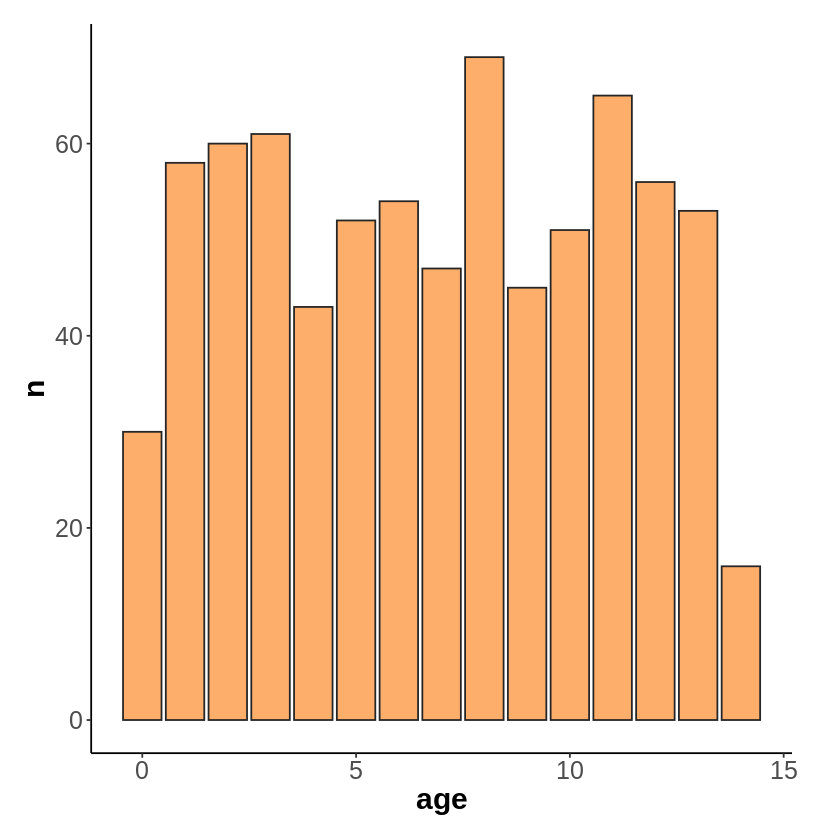

In [24]:
df_cohort_age <- df_cohort %>% count(age)

ggplot(data = df_cohort_age, aes(x = age, y = n))+
   geom_bar(stat = "identity", fill = "#fdae6b", color = "#252525")+
   theme

# Baseline data

We have the following information associated with malaria outcomes.



1.   **intervention**: Intervention or Control assignment (1: intervention, 0: control)
2.   **cn**: Living in the household with ceiling net or not (1: with cn, 0: without cn)
3. **non_bn**: Not using bed net (1: non-user, 0: user)
4. **vac**: With malaria vaccination for those aged 2–6 years old (1: vaccinated)
5. **age_c**: age category (1: age <= 2 yo, 0: age > 2 yo)
6. **rdt**: RDT results


In [25]:
df_baseline <- read.csv("./data_baseline.csv")
head(df_baseline)

,cluster_id,cohort_id,birth,age,intervention,cn,non_bn,vac,age_c,rdt
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,cl01,cl01_01,2012-03-26,13,1,1,0,0,0,0
2,cl01,cl01_02,2017-01-02,8,1,1,0,0,0,1
3,cl01,cl01_03,2024-08-15,0,1,1,0,0,1,0
4,cl01,cl01_04,2016-10-03,8,1,1,0,0,0,0
5,cl01,cl01_05,2015-09-10,9,1,1,0,0,0,0
6,cl01,cl01_06,2018-08-09,6,1,1,0,1,0,0


Transmission heterogeneity

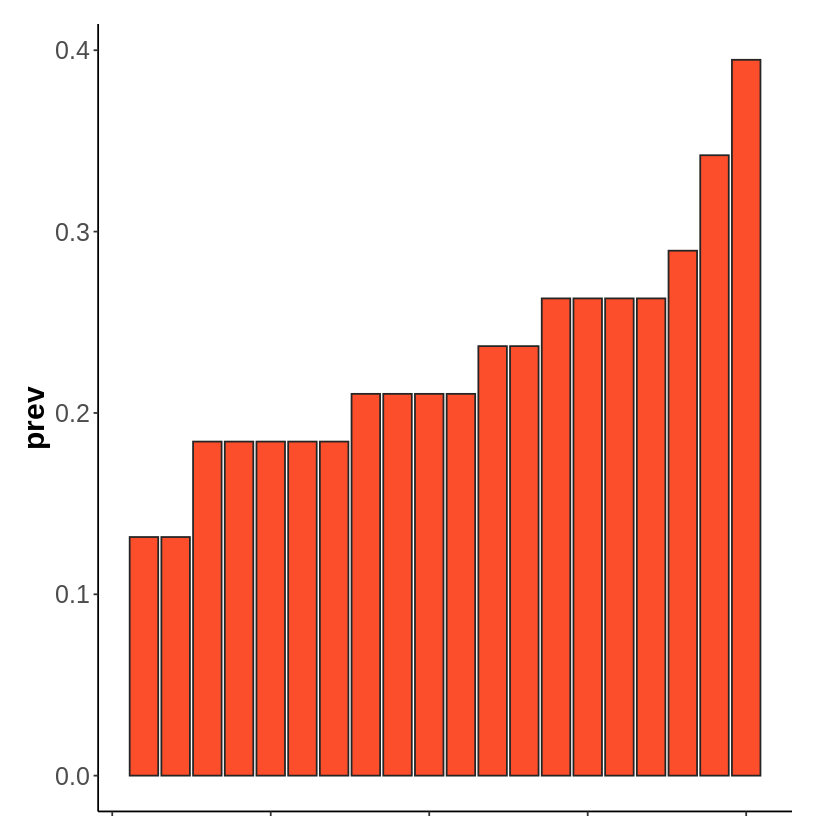

In [26]:
df_prev <- df_baseline %>%
  group_by(cluster_id) %>%
  count(rdt) %>%
  mutate(prev = n/sum(n)) %>%
  filter(rdt == 1) %>%
  arrange(prev) %>%
  ungroup() %>%
  mutate(order = row_number())

ggplot(data = df_prev, aes(x = order, y = prev))+
   geom_bar(stat = "identity", fill = "#fc4e2a", color = "#252525")+
   theme+
   theme(
          axis.title.x = element_blank(),
          axis.text.x = element_blank()
   )

# Analysis of perfect data

Suppose that we got to know the potential non-compliers, even those in the control arm.

**non_comp**: 1: non complier, 0: complier

In [92]:
df_full <- read.csv("./data_cohort_full.csv")
head(df_full)

,cohort_id,visit,outcome,cluster_id,name_f,name_l,birth,name_labtec,age,intervention,cn,non_comp,non_bn,vac,age_c
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,cl01_01,1,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,1,1,0,0,0,0
2,cl01_01,2,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,1,1,0,0,0,0
3,cl01_01,3,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,1,1,0,0,0,0
4,cl01_01,4,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,1,1,0,0,0,0
5,cl01_01,5,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,1,1,0,0,0,0
6,cl01_01,6,1,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,1,1,0,0,0,0


In [93]:
head(df_full %>% filter(intervention == 1 & non_comp == 1))

,cohort_id,visit,outcome,cluster_id,name_f,name_l,birth,name_labtec,age,intervention,cn,non_comp,non_bn,vac,age_c
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,cl01_10,1,0,cl01,Jasmine,Figueroa,2013/02/21,Nicole,12,1,0,1,0,0,0
2,cl01_10,2,0,cl01,Jasmine,Figueroa,2013/02/21,Nicole,12,1,0,1,0,0,0
3,cl01_10,3,0,cl01,Jasmine,Figueroa,2013/02/21,Nicole,12,1,0,1,0,0,0
4,cl01_10,4,0,cl01,Jasmine,Figueroa,2013/02/21,Nicole,12,1,0,1,0,0,0
5,cl01_10,5,0,cl01,Jasmine,Figueroa,2013/02/21,Nicole,12,1,0,1,0,0,0
6,cl01_10,6,0,cl01,Jasmine,Figueroa,2013/02/21,Nicole,12,1,0,1,0,0,0


In [94]:
df_full_count <- df_full %>%
    group_by(cohort_id) %>%
    summarise(
    num_pos = sum(outcome),
    total_visit = n()
  )

In [95]:
df_full2 <- df_full %>%
    dplyr::select(cluster_id, cohort_id, intervention, cn, non_comp, non_bn, vac, age_c) %>%
    left_join(df_full_count, by = "cohort_id") %>%
    distinct(cohort_id, .keep_all = T)

In [96]:
model <- glmer.nb(num_pos ~
                       cn +
                       non_comp +
                       non_bn +
                       vac +
                       age_c +
                       offset(log(total_visit)) +
                       (1 | cluster_id), data = df_full2)

In [102]:
print(exp(fixef(model)))
exp(confint(model, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model))[[2]],2)))

(Intercept)          cn    non_comp      non_bn         vac       age_c 
  0.1228262   0.5104337   1.4220579   1.2569324   0.7169945   1.3920507 


,2.5 %,97.5 %
(Intercept),0.09708239,0.1553966
cn,0.37308121,0.6983535
non_comp,1.05054529,1.9249513
non_bn,1.00850783,1.5665512
vac,0.57512895,0.8938537
age_c,1.10753742,1.7496521


[1] "Estimated efficacy of the ceiling net: 0.49"


In [98]:
model_itt <- glmer.nb(num_pos ~
                       intervention +
                       non_bn +
                       vac +
                       age_c +
                       offset(log(total_visit)) +
                       (1 | cluster_id), data = df_full2)

In [100]:
print(exp(fixef(model_itt)))
exp(confint(model_itt, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_itt))[[2]],2)))

 (Intercept) intervention       non_bn          vac        age_c 
   0.1286833    0.5776060    1.2834120    0.7067883    1.3569771 


,2.5 %,97.5 %
(Intercept),0.1018415,0.1625996
intervention,0.4202118,0.7939535
non_bn,1.0251107,1.6067986
vac,0.5650967,0.8840075
age_c,1.0753540,1.7123540


[1] "Estimated efficacy of the ceiling net: 0.42"


# Analysis of raw data

If you get to know who is the non complier, then we can estimate the data perfectly, but in reality it is not possible.



*   **symp**: 1: with malaria related symptoms
*   **rdt**: 1: malaria RDT positive



In [83]:
df_raw <- read.csv("./data_cohort_raw.csv")
df_raw

cluster_id,cohort_id,visit,avail,name_f,name_l,symp,rdt
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>
cl01,cl01_01,1,1,Sakeena,al-Hoque,0,0
cl01,cl01_02,1,1,Mitchell,Gonzales,0,NA
cl01,cl01_03,1,1,Anthony,Simmons,0,1
cl01,cl01_04,1,1,Alyssa,Rivera,0,1
cl01,cl01_05,1,1,Timothy,Vlajic,0,0
cl01,cl01_06,1,1,Mana,White,1,0
cl01,cl01_07,1,1,Chykeiljah,Rea,1,NA
cl01,cl01_08,1,1,Laneesha,Rusk,0,1
cl01,cl01_09,1,1,Mujaahida,el-Malak,0,0


We need the variable for clinical malaria, defined as having both symptoms and a positive RDT result.


In [84]:
df_raw2 <- df_raw %>%
    mutate(outcome = ifelse(rdt == 1 & symp == 1, 1, 0))

In [85]:
df_raw2

cluster_id,cohort_id,visit,avail,name_f,name_l,symp,rdt,outcome
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>
cl01,cl01_01,1,1,Sakeena,al-Hoque,0,0,0
cl01,cl01_02,1,1,Mitchell,Gonzales,0,NA,0
cl01,cl01_03,1,1,Anthony,Simmons,0,1,0
cl01,cl01_04,1,1,Alyssa,Rivera,0,1,0
cl01,cl01_05,1,1,Timothy,Vlajic,0,0,0
cl01,cl01_06,1,1,Mana,White,1,0,0
cl01,cl01_07,1,1,Chykeiljah,Rea,1,NA,NA
cl01,cl01_08,1,1,Laneesha,Rusk,0,1,0
cl01,cl01_09,1,1,Mujaahida,el-Malak,0,0,0


In [86]:
df_raw_count <- df_raw2 %>%
    group_by(cohort_id) %>%
    summarise(
    num_pos = sum(outcome,na.rm=T),
    total_visit = sum(avail)
  )




*   Combine with the baseline covariates
*   Calcluate incidence rate per person-year



In [87]:
df_raw3 <- left_join(df_raw_count, df_baseline) %>%
    distinct(cohort_id, .keep_all = T) %>%
    mutate(incidence_rate = 12*num_pos/total_visit)

Joining with `by = join_by(cohort_id)`


Get estimates

  - Intention to treeat vs Per protocol

In [88]:
# Intention to Treat
model_raw_itt <- glmer.nb(num_pos ~ intervention +
                       non_bn +
                       vac +
                       age_c +
                    　　offset(log(total_visit)) +
                       (1 | cluster_id), data = df_raw3)

In [89]:
# Per protocol
model_raw_pp <- glmer.nb(num_pos ~ cn +
                       non_bn +
                       vac +
                       age_c +
                    　　offset(log(total_visit)) +
                       (1 | cluster_id), data = df_raw3)

In [90]:
# Intention to Treat
print(exp(fixef(model_raw_itt)))
exp(confint(model_raw_itt, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_raw_itt))[[2]],2)))

 (Intercept) intervention       non_bn          vac        age_c 
   0.1351432    0.6433404    1.2570395    0.7277902    1.3188163 


,2.5 %,97.5 %
(Intercept),0.1073886,0.1700710
intervention,0.4710873,0.8785779
non_bn,1.0125886,1.5605039
vac,0.5874960,0.9015866
age_c,1.0547249,1.6490332


[1] "Estimated efficacy of the ceiling net: 0.36"


In [91]:
# Per protocol
print(exp(fixef(model_raw_pp)))
exp(confint(model_raw_pp, parm = "beta_", method = "Wald"))


print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_raw_pp))[[2]],2)))

(Intercept)          cn      non_bn         vac       age_c 
  0.1448369   0.4977574   1.2435779   0.7277495   1.3612633 


,2.5 %,97.5 %
(Intercept),0.1179066,0.1779183
cn,0.3794977,0.6528694
non_bn,1.0041448,1.5401026
vac,0.5884131,0.9000807
age_c,1.0907771,1.6988234


[1] "Estimated efficacy of the ceiling net: 0.5"


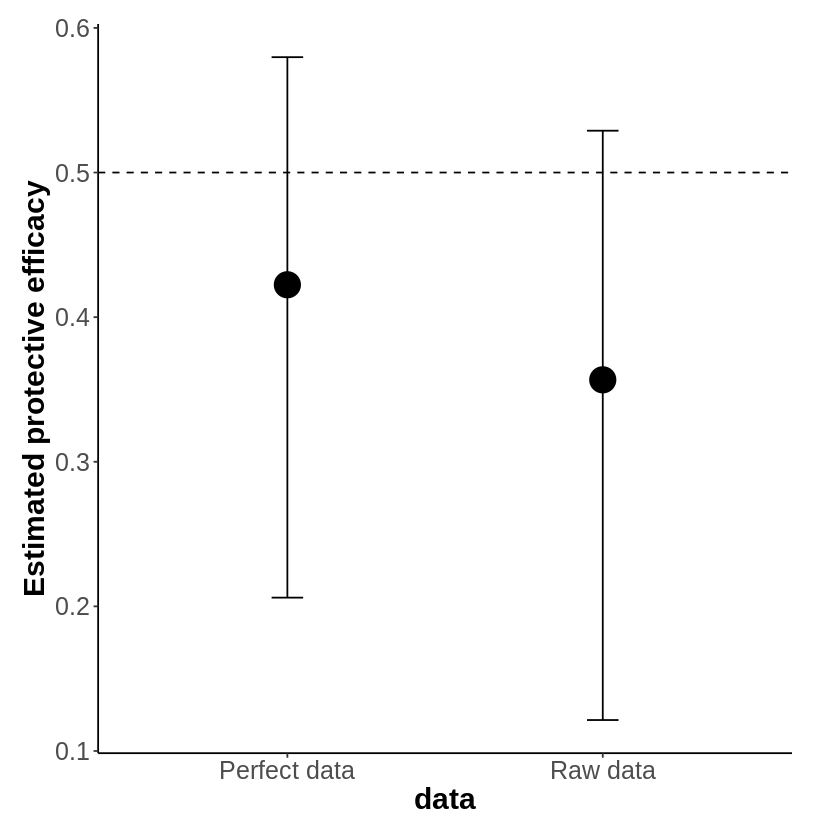

In [120]:
# Compare with the perfect data
m_raw_itt <- 1-exp(fixef(model_raw_itt))[[2]]
l_raw_itt <- 1-exp(confint(model_raw_itt, parm = "beta_", method = "Wald"))[[2,2]]
u_raw_itt <- 1-exp(confint(model_raw_itt, parm = "beta_", method = "Wald"))[[2,1]]

m_full_itt <- 1-exp(fixef(model_itt))[[2]]
l_full_itt <- 1-exp(confint(model_itt, parm = "beta_", method = "Wald"))[[2,2]]
u_full_itt <- 1-exp(confint(model_itt, parm = "beta_", method = "Wald"))[[2,1]]

data_res <- tibble(data = c("Raw data", "Perfect data"),
                   est = c(m_raw_itt, m_full_itt),
                   l = c(l_raw_itt, l_full_itt),
                   u = c(u_raw_itt, u_full_itt))

ggplot(data_res, aes(x = data, y = est)) +
  ylab("Estimated protective efficacy") +
  geom_point(size = 7) +
  geom_errorbar(aes(ymin = l, ymax = u), width = 0.1) +
  theme +
  geom_hline(yintercept = 0.5, linetype = 2)

# Data simulation


### Data generation process

1.   **Cluster-level random effect**: mean = 0, sd = 0.5
2.   **Intervention**: Randomly assign 50% of participants to receive the intervention, which reduces the risk of clinical malaria by 50%.
3.   **Compliance**: 10% of participants do not receive the intervention when allocated to the intervention arm due to a lack of health awareness; these individuals have a 20% higher risk of clinical malaria.
4.   **Bed net use**: 20% of participants do not use bed nets regularly and have a 40% higher risk of clinical malaria.
5.   **Malaria vaccine**: 70% of children aged 2–6 years receive a malaria vaccine, which reduces the risk of clinical malaria by 30%.
6. **Age**: Children aged 0–2 years have a 50% higher risk of clinical malaria compared to older children.

Without any of the above risk factors, the incidence rate is 1.5 per person-year, following a negative binomial distribution with a dispersion parameter of 1.2


\begin{align*}
y_{ij} &\sim NegBin(\lambda_{ij}, \theta) \\
\log{\lambda_{ij}} &= \alpha + x_{ij}^T\beta + u_j \\
\ u_j &\sim N(0, \sigma_{u}^2) \\
\end{align*}

where $y_{ij}$ denotes the total number of clinical malaria diagnosis for individual $i$ in a cluster $j$.







In [ ]:
df_cohort <- read.csv("./data/list_cohort.csv")
date_survey <- as.Date("2025/04/01")
df_cohort_2 <- df_cohort %>%
  mutate(birth = ifelse(cohort_id == "cl01_11", "2020/11/30", birth)) %>%
  mutate(age = floor(interval(birth, date_survey) / years(1))) %>%
  group_by(cluster_id) %>%
  mutate(re = rnorm(1, mean = 0, sd = 0.3)) %>%
  mutate(intervention = ifelse(as.numeric(str_extract(cluster_id, "\\d+")) %% 2 == 1,1,0)) %>%
  ungroup() %>%
  mutate(non_comp = rbinom(nrow(df_cohort), 1, 0.10),
         non_bn = rbinom(nrow(df_cohort), 1, 0.2),
         vac = case_when(age >= 2 & age <= 6 ~ rbinom(nrow(df_cohort), 1, 0.70),
                         TRUE ~ 0),
         age_c = ifelse(age <= 2, 1, 0)) %>% # 1: young, 0: old
  mutate(cn = ifelse(intervention == 1 & non_comp == 0, 1, 0))

In [ ]:
lambda <- exp(log(1.5)+df_cohort_2$re+
            log(0.5)*df_cohort_2$cn+
            log(1.2)*df_cohort_2$non_comp+
            log(1.4)*df_cohort_2$non_bn+
            log(0.7)*df_cohort_2$vac+
            log(1.5)*df_cohort_2$age_c
            )
theta <- 1.2
num_pos <- rnegbin(nrow(df_cohort_2), mu = lambda, theta = theta)
df_cohort_2$num_pos <- num_pos

In [ ]:
print(df_cohort_2$num_pos)

  [1]  1  0  1  0  1  2  1  0  0  0  0  0  0  2  0  2  0  0  0  0  1  0  2  0  0
 [26]  0  3  0  1  0  3  0  4  1  0  0  0  1  1  1  1  1  0  0  3  1  1  1  2  0
 [51]  4  1  0  0  0  0  1  0  1  0  0  3  0  0  1  6  0  0  2  4  2  0  0  5  0
 [76]  2  0  0  1  0  1  2  0  6  0  2  1  0  6  0  0  1  1  0  0  3  3  4  2  4
[101]  0  1  0  1  1  1  3  0  1  0  1  0  1  0  4  7  1  3  1  2  1  2  0  2  2
[126]  1  2  3  1  5  2  5  1  1  4  3  8  3  1  2  1  3  2  0  0  0  5  2  0  0
[151] 10  0  2  2  6  2  0  2  2  0  0  0  0  0  0  3  4  0  1  0  0  2  1  0  0
[176]  3  1  1  0  3  1  0  1  0  0  0  2  0  0  4  5  0  1  0  1  4  0  3  3  0
[201]  5  2  0  3  0  2  1  6  2  2  1  0  2  3  1  9  4  0  1  4  6  1  5  0  0
[226]  0  0  7  5  0  4  2  1  0  9  0  0  1  1  2  0  0  1  2  0  1  1  0  0  1
[251]  0  4  1  0  2  2  0  0  1  1  0  1  2  0  3  0  4  0  0  3  0  1  1  1  1
[276]  0  3  1  1  0  0  3  8  0  0  0  1  0  3  4  0  2  0  3  0  0  1  0  0  1
[301]  4  2  1  3  1  1  0  

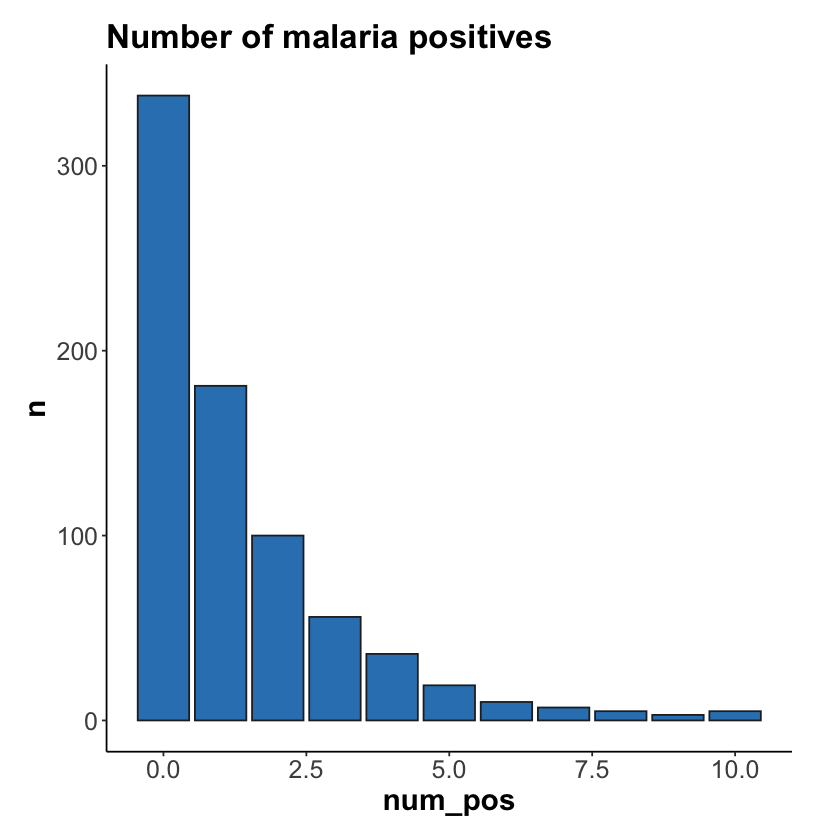

In [ ]:
df_num_pos <- df_cohort_2 %>% count(num_pos)

ggplot(data = df_num_pos, aes(x = num_pos, y = n))+
   geom_bar(stat = "identity", fill = "#3182bd", color = "#252525")+
   ggtitle("Number of malaria positives")+
   theme